In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization,
    Activation
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from keras.applications import VGG16

2024-05-16 16:20:50.241685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 16:20:50.241773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 16:20:50.409891: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def no_of_subdirs(directory,set_name):
    counts={}
    for item in os.listdir(directory):
        item_path=os.path.join(directory,item)
        if os.path.isdir(item_path):
            counts[item]=len(os.listdir(item_path))
    df=pd.DataFrame(counts,index=[set_name])
    return df

In [3]:
train_dataset='/kaggle/input/fer2013/train'
test_dataset='/kaggle/input/fer2013/test'
train_count=no_of_subdirs(train_dataset,'train')
test_count=no_of_subdirs(test_dataset,'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


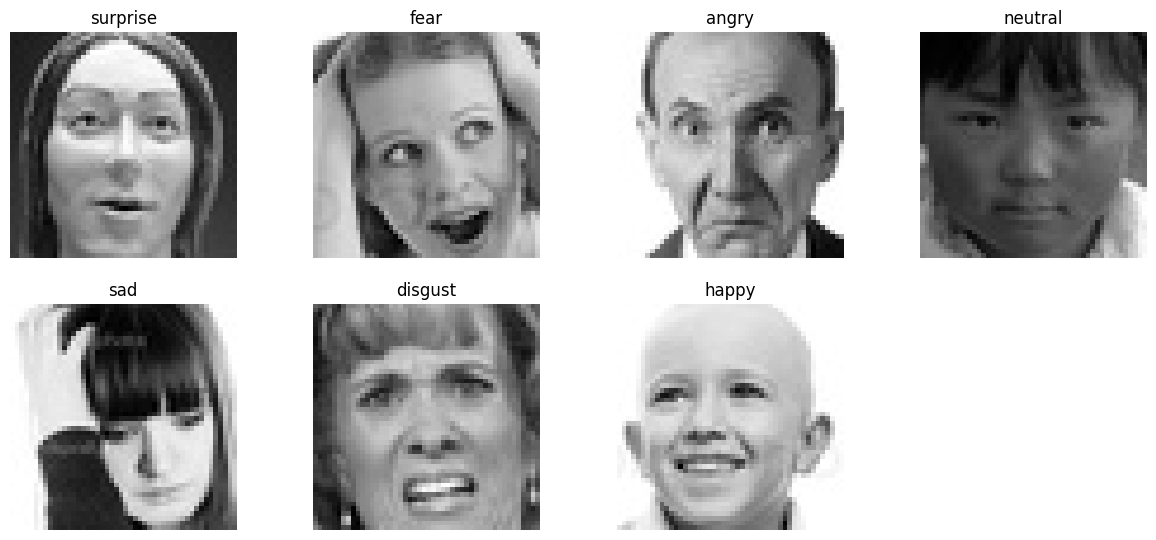

In [4]:
emotions=os.listdir(train_dataset)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
    folder=os.path.join(train_dataset,emotion)
    img_path=os.path.join(folder,os.listdir(folder)[6])
    img=plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [5]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:

def load_dataset(directory, subset, target_size, batch_size, class_mode):
    return train_datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        class_mode=class_mode,
        subset=subset,
        batch_size=batch_size
    )

train_dataset = load_dataset(
    '/kaggle/input/fer2013/train',
    'training',
    (48, 48),
    64,
    'categorical'
)
valid_dataset = load_dataset(
    '/kaggle/input/fer2013/train',
    'validation',
    (48, 48),
    64,
    'categorical'
)

test_dataset = load_dataset(
    '/kaggle/input/fer2013/test',
    None,
    (48, 48),
    64,
    'categorical'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:

base_model = VGG16(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet"
)


for layer in base_model.layers[:-4]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax')
])

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.build(input_shape=(None, 48, 48, 3))


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,737,063 (56.22 MB)

 Trainable params: 7,100,519 (27.09 MB)

 Non-trainable params: 7,636,544 (29.13 MB)

In [12]:
def f1_score(y_true, y_pred):

    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    

    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    

    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1_val


In [13]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

lrd = ReduceLROnPlateau(
    monitor='val_loss',
    patience=20,
    verbose=1,
    factor=0.50,
    min_lr=1e-10
)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(
    verbose=1,
    patience=20
)

In [14]:

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=60,
    verbose=1,
    callbacks=[lrd, mcp, es]
)

Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/359 ━━━━━━━━━━━━━━━━━━━━ 1:57:02 20s/step - accuracy: 0.8415 - auc: 0.5434 - f1_score: 0.0000e+00 - loss: 2.1536 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1715876516.312204      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715876516.339804      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/359 ━━━━━━━━━━━━━━━━━━━━ 2:18 474ms/step - accuracy: 0.8502 - auc: 0.5556 - f1_score: 0.0268 - loss: 2.1156 - precision: 0.1909 - recall: 0.0146

W0000 00:00:1715876547.094675      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8534 - auc: 0.5930 - f1_score: 0.0172 - loss: 1.9823 - precision: 0.2110 - recall: 0.0092

W0000 00:00:1715876656.566511      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715876695.008741      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 199s 500ms/step - accuracy: 0.8534 - auc: 0.5931 - f1_score: 0.0172 - loss: 1.9819 - precision: 0.2111 - recall: 0.0092 - val_accuracy: 0.8571 - val_auc: 0.6836 - val_f1_score: 0.0000e+00 - val_loss: 1.7766 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 146ms/step - accuracy: 0.8570 - auc: 0.6698 - f1_score: 0.0163 - loss: 1.7868 - precision: 0.4676 - recall: 0.0084 - val_accuracy: 0.8572 - val_auc: 0.6995 - val_f1_score: 0.0024 - val_loss: 1.7366 - val_precision: 0.5833 - val_recall: 0.0012 - learning_rate: 0.0010
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 51s 139ms/step - accuracy: 0.8578 - auc: 0.6951 - f1_score: 0.0404 - loss: 1.7375 - precision: 0.5629 - recall: 0.0211 - val_accuracy: 0.8591 - val_auc: 0.7312 - val_f1_score: 0.0363 - val_loss: 1.6700 - val_precision: 0.7786 - val_recall: 0.0190 - learning_rate: 0.0010
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy

In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         name='Accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy',
                  legend=dict(x=0.7, y=0.9),
                  width=800,
                  height=600,
                  plot_bgcolor='rgb(17, 17, 17)',
                  paper_bgcolor='rgb(17, 17, 17)',
                  font=dict(color='white'))
fig.show()

In [16]:
print("\nEvaluating the model on the test dataset...")
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_dataset)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Evaluating the model on the test dataset...
  1/113 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.8705 - auc: 0.8280 - f1_score: 0.2750 - loss: 1.4059 - precision: 0.6875 - recall: 0.1719

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 272ms/step - accuracy: 0.8773 - auc: 0.8210 - f1_score: 0.3215 - loss: 1.4189 - precision: 0.7615 - recall: 0.2058

Test Loss: 1.4173
Test Accuracy: 0.8776
Test Precision: 0.7689
Test Recall: 0.2044
Test AUC: 0.8217
Test F1 Score: 0.3206


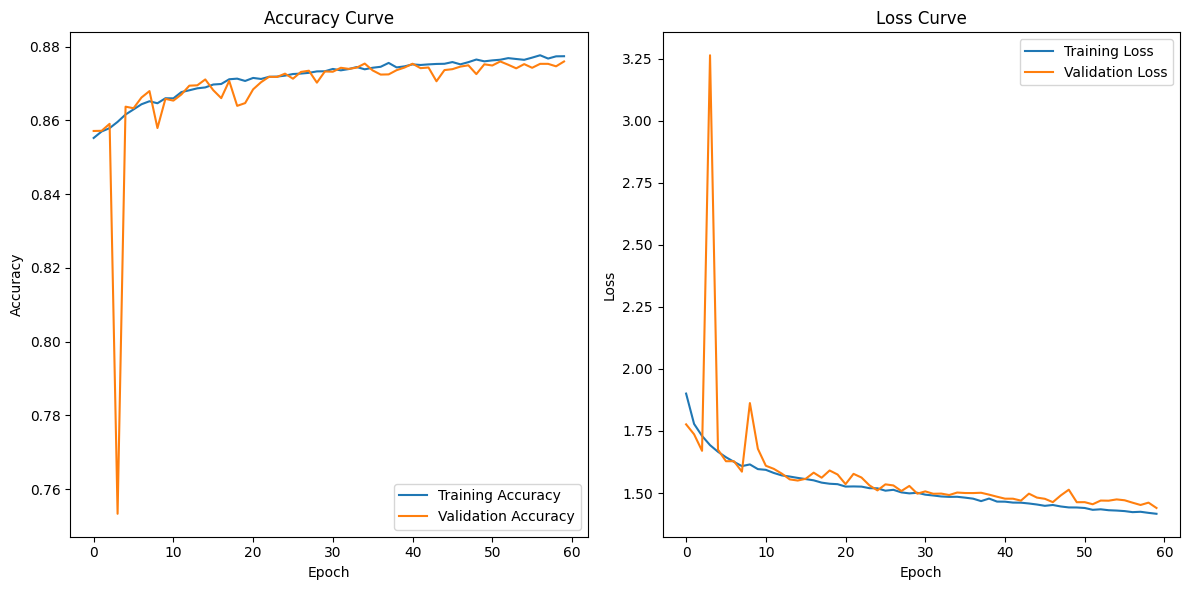

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

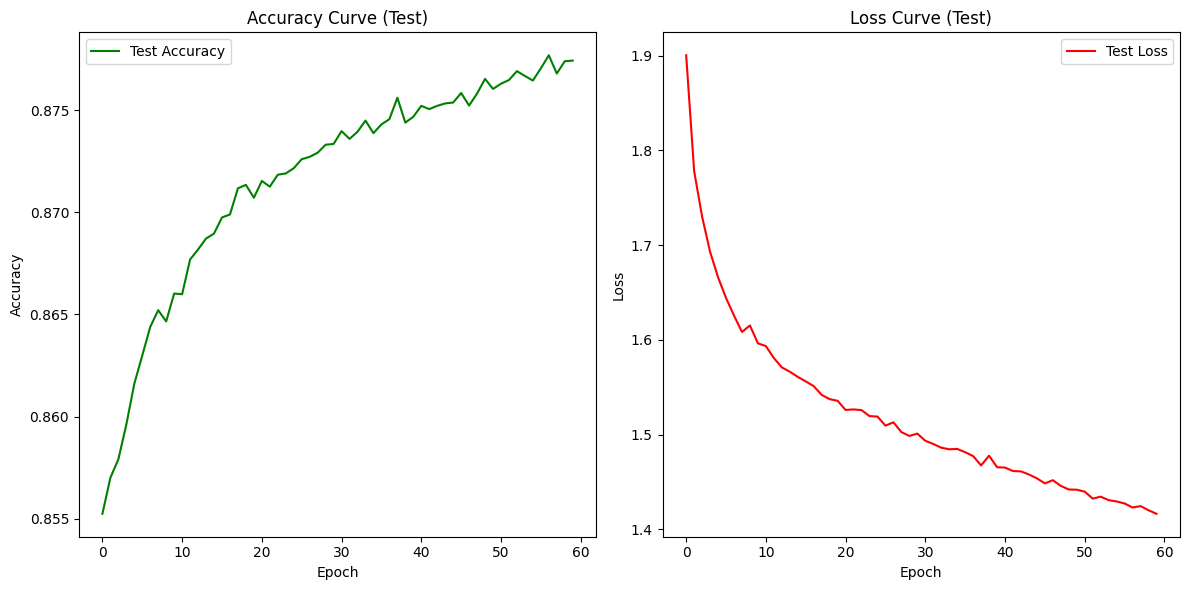

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Test Accuracy', color='green')
plt.title('Accuracy Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Test Loss', color='red')
plt.title('Loss Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()

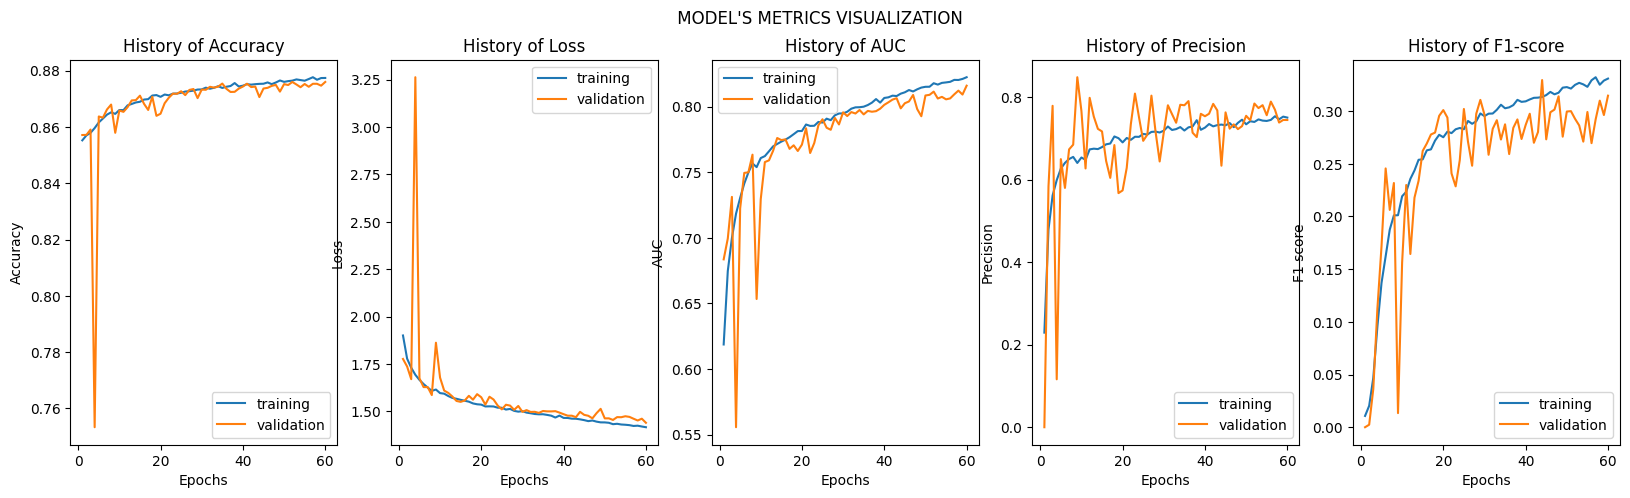

In [20]:

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
64


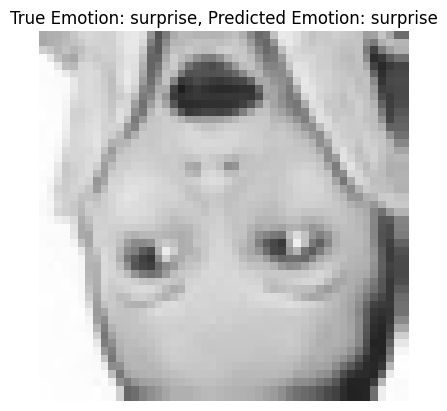

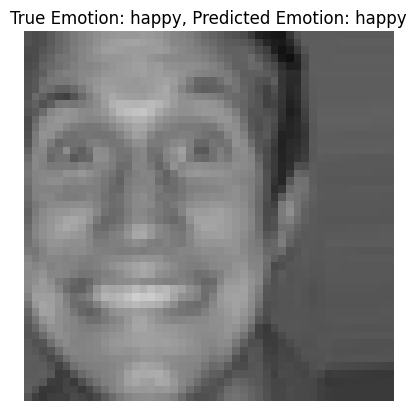

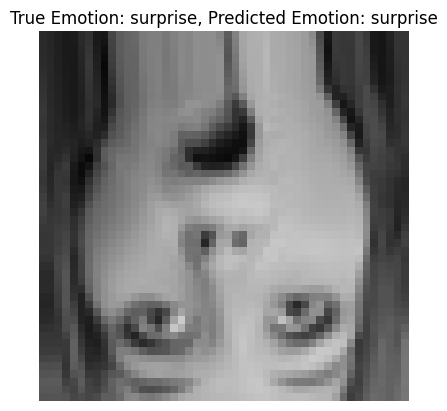

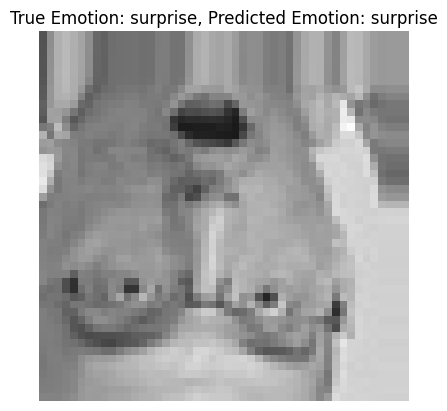

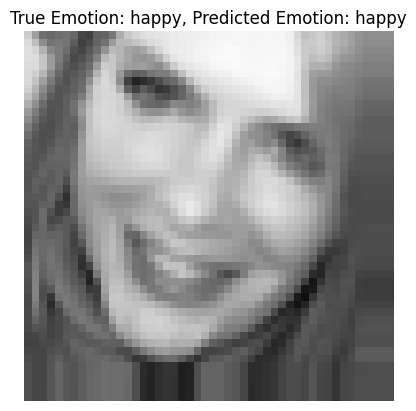

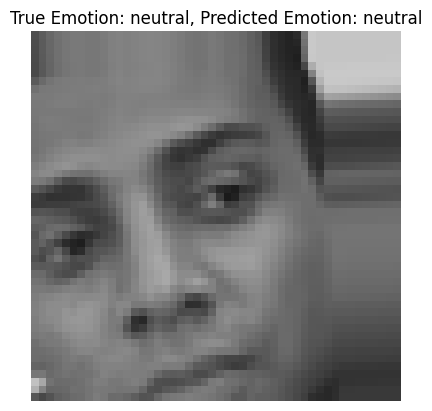

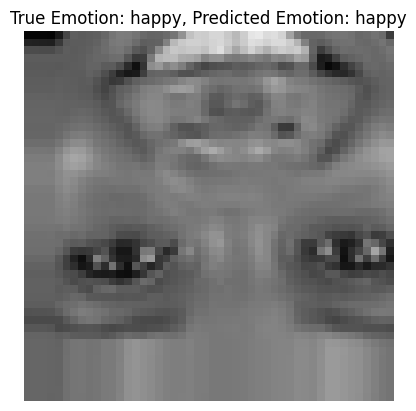

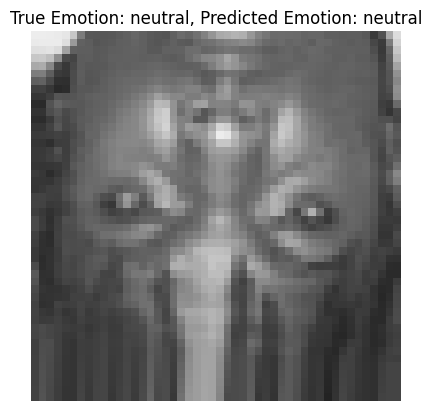

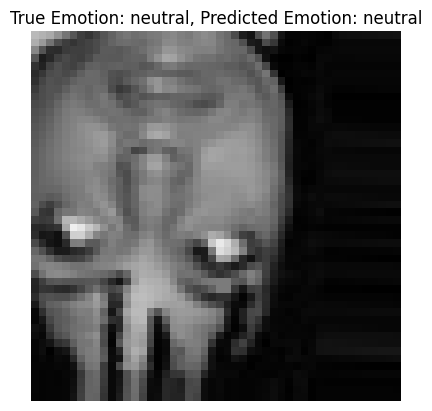

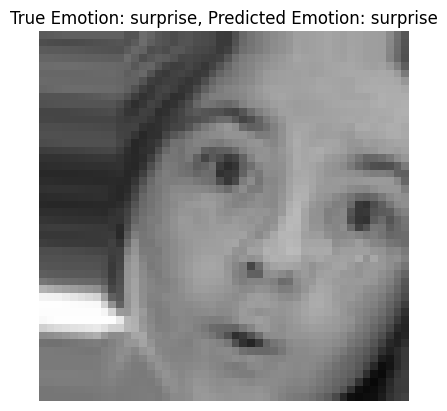

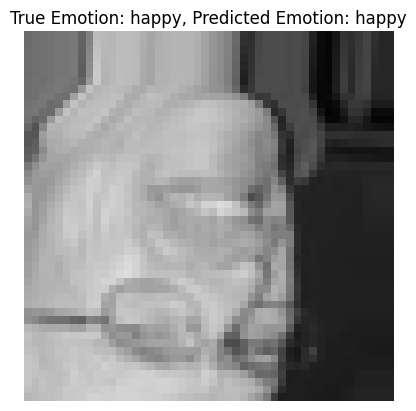

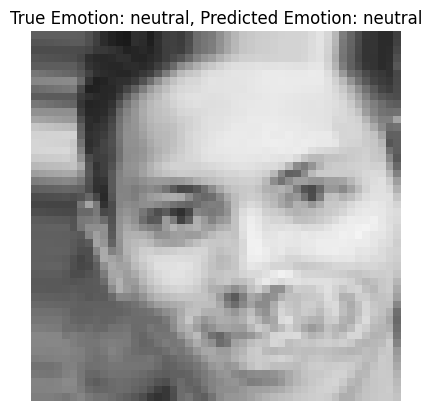

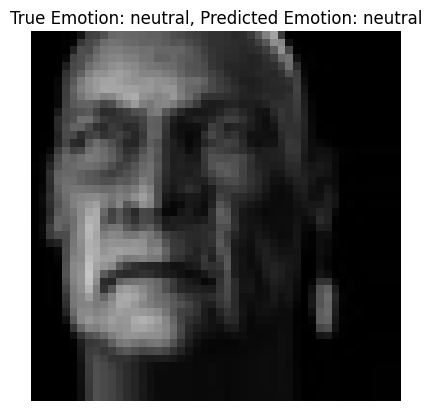

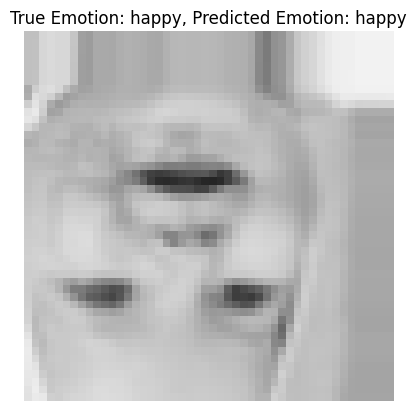

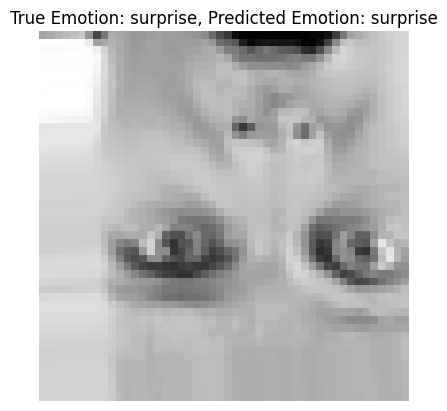

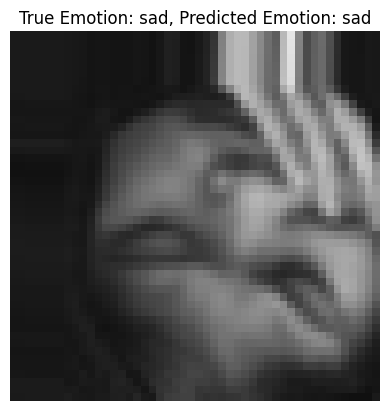

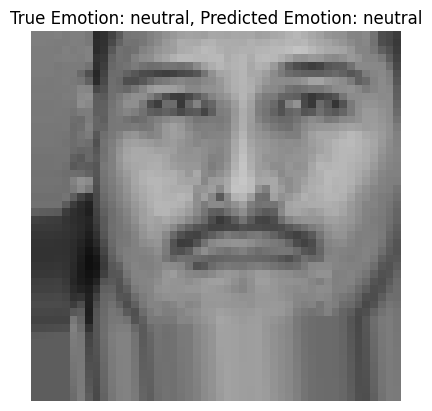

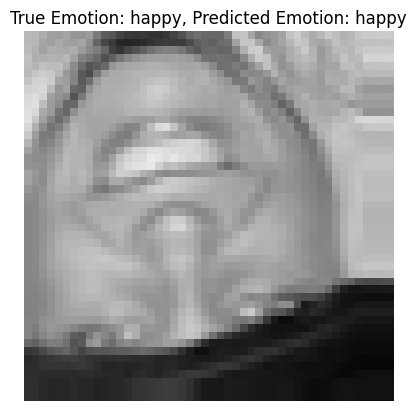

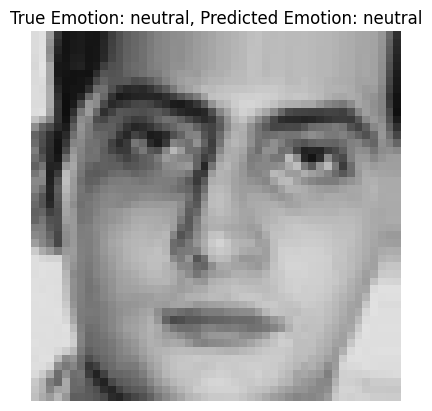

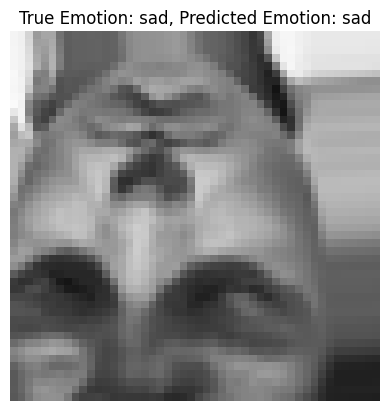

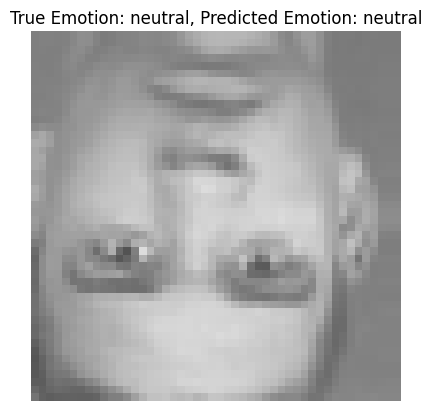

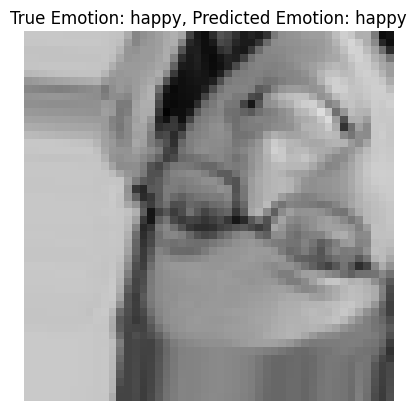

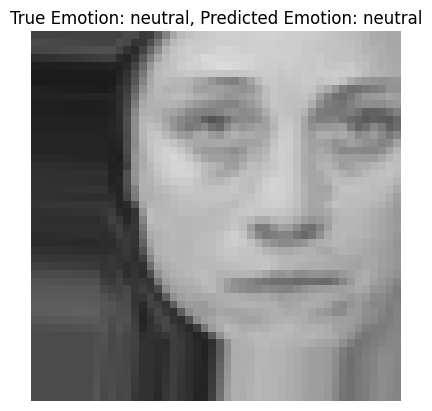

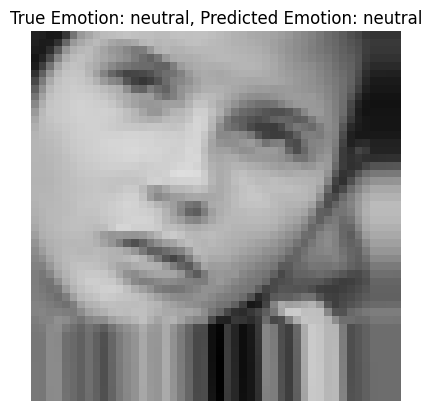

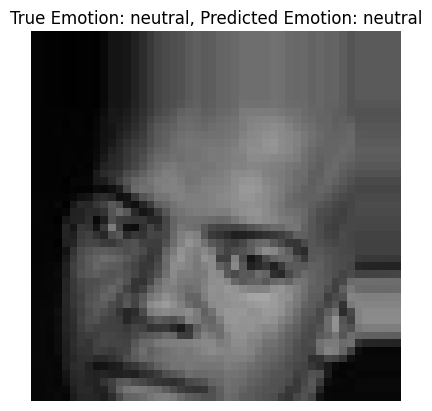

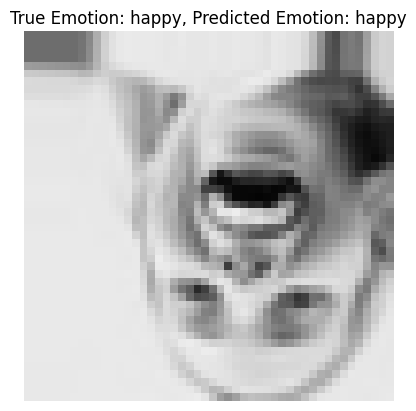

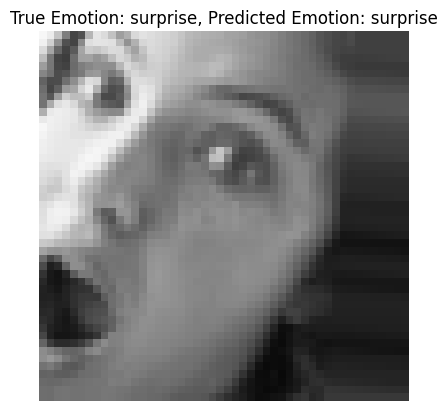

27


In [21]:
for images, labels in test_dataset:

    predictions = model.predict(images)
    predicted_emotions = np.argmax(predictions, axis=1)
    class_labels = test_dataset.class_indices
    emotion_labels = {value: key for key, value in class_labels.items()}
    print(len(images))
    coun = 0

    for i in range(len(images)):
        image = images[i]
        true_emotion = emotion_labels[np.argmax(labels[i])]
        predicted_emotion = emotion_labels[predicted_emotions[i]]
        
        if(true_emotion == predicted_emotion):
            coun = coun + 1
            plt.imshow(image)
            plt.title(f'True Emotion: {true_emotion}, Predicted Emotion: {predicted_emotion}')
            plt.axis('off')
            plt.show()
    print(coun)
    break


In [22]:
model.save("vggmodelfinal.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [ ]:
import pickle

with open('/kaggle/working/model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import joblib

joblib.dump(model, 'model.joblib')

In [ ]:
modmodel = tf.keras.models.load_model("vggmodelfinal.h5")

In [ ]:
loaded_model = load_model('vggmodelfinal.h5', custom_objects={'YourCustomLayer': YourCustomLayer})